# Infection Detection with Convolutional Neural Network

Kevin McDonough

![title](Images/Digital_healthcare_logo.png)

## Overview

This project analyzes over 1200 images of infected wounds, non-infected wounds and healthy skin. Using these images, as well as image generation techniques such as data augmentation, a convolutional neural network was constructed in order to predict the likelihood of a wound being infected. The model was then deployed on a Steamlit app, allowing a user to upload an image at their convenience. 

## Business Problem / Use Case 

The current cost of treating wounds in the U.S. is ~$25 billion per year. Infections represent a large proportion of this, and if an infection is not detected early it can lead to significant economic and human costs. Due to potential barriers to seeing a doctor, such as expensive bills and inability to travel, patients with wounds who are in need of care occasionally put off doctor's appointments. Deploying a image classification app to screen patients would help solve these issues by allowing patients to upload images from the convenience of their home at no cost. The app would then let them know if they need to see a doctor. An additional benefit is that, by screening out patients with a low probability of infection, the app would also save doctors time by allowing them to focus on patients that are truly at risk. 

## Data Understanding

The dataset consists of over 1200 images. There are two classes: Infection and No Infection. The two classes are roughly equally represented in the overall dataset -- there are around 610 images in each class. The Infection class is made up of wounds with varying degrees of infection. Around 50% of the No Infection class contains images of cuts, scrapes and scabs and the other 50% is images of healthy skin with no wound. This data was collected by scraping google images. Additionally, several images are from the [Medetec Wound Database](http://www.medetec.co.uk/files/medetec-image-databases.html)

#### Importing packages and loading the datasets

In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import shutil
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import seaborn as sns
import skimage.io 
import skimage.segmentation
import copy
import sklearn
from sklearn.linear_model import LinearRegression

#### Loading the data

In [2]:
infection_filenames = os.listdir("Data/Infection")

In [3]:
len(infection_filenames)

611

In [4]:
no_infection_filenames = os.listdir("Data/No_Infection")

In [5]:
len(no_infection_filenames)

616

The code above shows the number of images in each class: there are 611 images of infected wounds and 616 images in the no infection class. Next let's take a look at an image from each class for context. Apologies in advance for the kind of graphic images

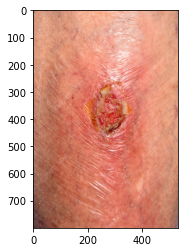

In [35]:
sample = random.choice(infection_filenames)
image = load_img("Data/Infection/"+sample)
plt.imshow(image)

Above is an example of a wound that is infected. 

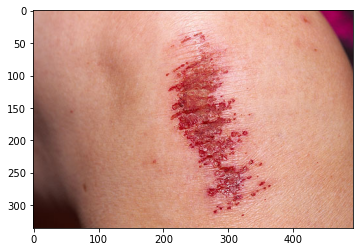

In [37]:
sample = random.choice(no_infection_filenames)
image = load_img("Data/No_Infection/"+sample)
plt.imshow(image)

The above image if an example of a scrape that is not infected. I included scrapes, scabs and cuts in the "No Infection" class so that the model is not simply predicting whether a wound is present or not -- it is predicting whether an infection is present.

## Data Preparation

#### Train Test Split

In order to feed the data into a CNN model we need to create a seperate folder for each class. This makes it a little tricky to create a train test split, because we are not simply splitting the data, we also have to ensure that each image ends up in the correctly labeled category within the train and test folders. The code below pulls the images from the main data folder then creates a train and test folder that has the appropriately labeled images. 75% of the images will end up in the train folder and 25% of the images will be used for validating the model. I don't want to overwrite the initial train test split that I made, so I have commented the cell out for now.

In [11]:
# rootdir= '/Users/kevinmcdonough/Documents/Flatiron/capstone/project/Capstone/Data/' #path of the original folder

# classes = ['Infection', 'No_Infection']

# for i in classes:
#     os.makedirs(rootdir +'/train/' + i)

#     os.makedirs(rootdir +'/test/' + i)

#     source = rootdir + '/' + i

#     allFileNames = os.listdir(source)

#     np.random.shuffle(allFileNames)

#     test_ratio = 0.25

#     train_FileNames, test_FileNames = np.split(np.array(allFileNames),
#                                                           [int(len(allFileNames)* (1 - test_ratio))])

#     train_FileNames = [source+'/'+ name for name in train_FileNames.tolist()]
#     test_FileNames = [source+'/' + name for name in test_FileNames.tolist()]

#     for name in train_FileNames:
#       shutil.copy(name, rootdir +'/train/' + i)

#     for name in test_FileNames:
#       shutil.copy(name, rootdir +'/test/' + i)

#### Data Augmentation

The dataset is pretty small (610 images per class) so we can use data augmentation to create more images by flipping, shifting and zooming. Because the images are closeups of skin, orientation doesn't matter and horizontal and vertical shifts can be used. Data augmentation can be done using Keras' ImageDataGenerator.

In [60]:
image_size = (300,300)
batch_size = 400
labels = ['Infection','No_Infection']

for label in labels:
  datagen_kwargs = dict(rescale=1./255)  
  dataflow_kwargs = dict(target_size=image_size, 
                        batch_size=batch_size, interpolation="bilinear")

  train_datagen = ImageDataGenerator(
    rotation_range=20,
    vertical_flip=True,
    width_shift_range=0.5, height_shift_range=0.1,
    shear_range=0.1, zoom_range=0.1,
    **datagen_kwargs)

  train_generator = train_datagen.flow_from_directory(
      'Data/modeling/train', subset="training", shuffle=True, save_to_dir='Data/modeling/Aug_images/'+label+'/', save_prefix='aug', classes=[label], **dataflow_kwargs)
  
  # Following line triggers execution of train_generator
  batch = next(train_generator) 

Found 454 images belonging to 1 classes.
Found 460 images belonging to 1 classes.


In [61]:
infection_filenames = os.listdir("Data/modeling/Aug_images/Infection")
no_infection_filenames = os.listdir("Data/modeling/Aug_images/No_Infection")

In [62]:
print(len(infection_filenames))
print(len(no_infection_filenames))

400
400


The cells above pull 400 images from each class subfolder within the train folder and use them to create new images in which the original image is flipped vertically and shifted. One thing to note is that, in order for the code to work, the Aug_images folder has to be created with an empty subfolder for each class.

Just to ensure we have enough, let's do one more batch with a horizontal flip and play with some of the other parameters as well. Because these images are closups on the skin, data augmentation makes sense with this dataset. 

In [63]:
image_size = (300,300)
batch_size = 400
labels = ['Infection','No_Infection']

for label in labels:
  datagen_kwargs = dict(rescale=1./255)  
  dataflow_kwargs = dict(target_size=image_size, 
                        batch_size=batch_size, interpolation="bilinear")

  train_datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    width_shift_range=0.2, height_shift_range=0.1,
    shear_range=0, zoom_range=0,
    **datagen_kwargs)

  train_generator = train_datagen.flow_from_directory(
      'Data/modeling/train', subset="training", shuffle=True, save_to_dir='Data/modeling/Aug_images/'+label+'/', save_prefix='aug_2', classes=[label], **dataflow_kwargs)
  
  # Following line triggers execution of train_generator
  batch = next(train_generator) 

Found 454 images belonging to 1 classes.
Found 460 images belonging to 1 classes.


In [64]:
infection_filenames = os.listdir("Data/modeling/Aug_images/Infection")
no_infection_filenames = os.listdir("Data/modeling/Aug_images/No_Infection")

In [65]:
print(len(infection_filenames))
print(len(no_infection_filenames))

800
800


The cells above pull 400 images from each class subfolder within the train folder and use them to create new images in which the original image is flipped horizontally and shifted. Note that there are now 800 images in each of our class subfolders now.

Lastly let's add the original train images in to our augmented folder

In [66]:
train_infection_dir = 'Data/modeling/train/Infection/'
file_names = os.listdir(train_infection_dir)
train_file_names = [train_infection_dir+'/'+ name for name in file_names]
for name in train_file_names:
    shutil.copy(name, 'Data/modeling/Aug_images/Infection')

Now we do the same exercise for the not infected photos

In [67]:
train_no_infection_dir = 'Data/modeling/train/No_Infection/'
file_names = os.listdir(train_no_infection_dir)
train_file_names = [train_no_infection_dir+'/'+ name for name in file_names]
for name in train_file_names:
    shutil.copy(name, 'Data/modeling/Aug_images/No_Infection/')

In [70]:
infection_filenames = os.listdir("Data/modeling/Aug_images/Infection")
no_infection_filenames = os.listdir("Data/modeling/Aug_images/No_Infection")

In [71]:
print(len(infection_filenames))
print(len(no_infection_filenames))

1258
1262


We have now tripled our training set to include over 1250 images for each class.

## Model Building 

For our first model, we will use the data from the original Train / Test folders. This will allow us to evaluate the effect of data augmentation on our model. Let's prepare the images to feed into the model by rescaling and resizing and feeding them into our generator:

In [72]:
image_size = (300,300)
batch_size = 32
image_width = 300
image_height = 300
image_channels = 3

In [73]:
train_datagen = ImageDataGenerator(rescale=1./255)

In [75]:
train_generator = train_datagen.flow_from_directory(
    "Data/modeling/train",
    target_size=image_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)

Found 914 images belonging to 2 classes.


The above code takes the images from our train folder and puts them in a format that can be used in our convolutional neural network. As you can see, the training folder conists of 914 images belonging to each class.

In [76]:
# total_train = len(train_generator.filenames)

In [77]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [78]:
test_generator = test_datagen.flow_from_directory(
    "Data/modeling/test/", 
    target_size=image_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 302 images belonging to 2 classes.


Similarly, the code above takes images from the test folder. The test folder consists of 302 images belonging to our two classes: infection and no infection

In [79]:
# total_test = len(test_generator.filenames)

#### First Model 

We are now ready to create a convolutional neural network. The code cells below create the model. We will optimize for accuracy and use our test folder to validate. The model will consist of a convolutional input layer followed by a dense layer and an output layer. We will use callbacks to save the epoch containing our best performing weights. Additionally, dropout layers will be used to prevent overfitting.

In [80]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_width, image_height, image_channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 298, 298, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 149, 149, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 710432)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               90935424  
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               5

In [81]:
epochs = 10

history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=test_generator,
    batch_size=batch_size,
    callbacks=callbacks_list
)

Epoch 1/10
29/29 [==============================] - ETA: 0s - loss: 0.9583 - accuracy: 0.6893
Epoch 00001: val_accuracy improved from -inf to 0.50993, saving model to weights.best.hdf5
29/29 [==============================] - 173s 6s/step - loss: 0.9583 - accuracy: 0.6893 - val_loss: 0.9642 - val_accuracy: 0.5099
Epoch 2/10
29/29 [==============================] - ETA: 0s - loss: 0.5523 - accuracy: 0.7812
Epoch 00002: val_accuracy improved from 0.50993 to 0.53311, saving model to weights.best.hdf5
29/29 [==============================] - 145s 5s/step - loss: 0.5523 - accuracy: 0.7812 - val_loss: 0.6863 - val_accuracy: 0.5331
Epoch 3/10
29/29 [==============================] - ETA: 0s - loss: 0.4242 - accuracy: 0.8337
Epoch 00003: val_accuracy did not improve from 0.53311
29/29 [==============================] - 188s 6s/step - loss: 0.4242 - accuracy: 0.8337 - val_loss: 0.9277 - val_accuracy: 0.5000
Epoch 4/10
29/29 [==============================] - ETA: 0s - loss: 0.3216 - accuracy: 0

In [82]:
best_model = load_model("weights.best.hdf5") #loads the callback for best weights 

In [83]:
y_pred = best_model.predict(test_generator) # generates predictions on the test set using our model

In [84]:
test_preds = np.argmax(y_pred, axis=-1) # selects the class with the highest probability 

In [85]:
conf = confusion_matrix(test_generator.classes, test_preds)
conf

array([[ 11, 140],
       [  0, 151]])

In [86]:
test_generator.class_indices

{'Infection': 0, 'No_Infection': 1}

This model did not perform very well! It predominantly predicted the "no infection" class and the best accuracy achieved was .536. Let's see if we can do better. 

## Model 2 

Due to the long computational time of these models, I built the next one on google colab. I saved the best-performing weights locally in my directory and will load this file. I also changed a couple parameters such as batch-size so I will rerun the test images through the new generator to reflect these changes.

In [87]:
image_width = 300
image_height = 300
image_channels = 3
image_size = (image_width, image_height)
batch_size = 10 

In [88]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [89]:
test_generator = test_datagen.flow_from_directory(
    "Data/modeling/test/", 
    target_size=image_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False 
)

Found 302 images belonging to 2 classes.


In [40]:
best_model = load_model("my_model.h5") # loads the model 

In [91]:
y_pred = best_model.predict(test_generator)

In [92]:
test_preds = np.argmax(y_pred, axis=-1)

In [93]:
conf = confusion_matrix(test_generator.classes, test_preds)
conf

array([[139,  12],
       [ 17, 134]])

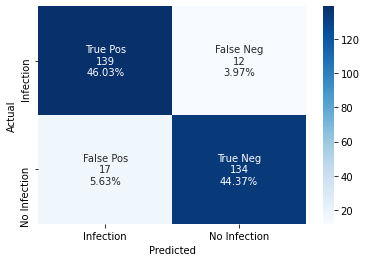

In [96]:
group_names = ['True Pos', 'False Neg','False Pos','True Neg']

group_counts = ["{0:0.0f}".format(value) for value in
                conf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     conf.flatten()/np.sum(conf)]
               
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf, annot=labels, fmt='', cmap='Blues', xticklabels=['Infection', 'No Infection'], yticklabels=['Infection', 'No Infection']);
plt.ylabel('Actual');
plt.xlabel('Predicted');

This model is a drastic improvement over the first. By utilizing data augmentation and adding another hidden layer, the accuracy improved from .53 to .904. Additionally, the false negative rate dropped to 3.97% -- this is important because we don't want to classify wounds as "not infected" if an infection is present.

#### Model Prediction Example

Let's take a look at the model output using an example image:

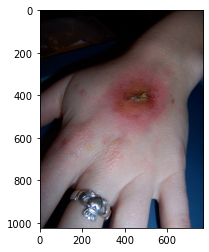

In [36]:
img_path = 'Images/Infection_Example.jpg'

img = load_img(img_path)
plt.imshow(img)
plt.show()

This is an image of a hand with an infected image. We will preprocess the image and feed it to our model to see how it classifies it.

In [37]:
img = load_img(img_path, target_size=(300,300))
img_array = np.array(img).astype('float32')/255
img_array = img_array.reshape(300,300,3)
img_array = np.expand_dims(img_array, axis=0)

In [38]:
img_array.shape

(1, 300, 300, 3)

In [41]:
pred = best_model.predict(img_array)
pred

array([[0.9808086 , 0.01919134]], dtype=float32)

In the output above, the model is assigning a .98 probability of infection and a .02 probability of no infection

In [42]:
img_pred = np.argmax(pred, axis=-1)
img_pred

array([0])

In our model 0 represents infection and 1 represents infection. the cell above demonstrates that the model is classifying this image as infected.

#### Using Lime to Show Model Prediction

LIME (Local Interpretable Model-agnostic Explanations) can be used to generate explanations for image classification tasks. The basic idea is to understand why a machine learning model (deep neural network) predicts that an instance (image) belongs to a certain class. Below, we will see what our model is using to classify the example image 

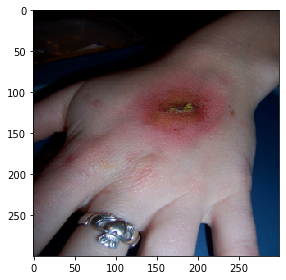

In [43]:
Xi = skimage.io.imread("Images/Infection_Example.jpg")
Xi = skimage.transform.resize(Xi, (300,300)) 
Xi = (Xi - 0.5)*2 #Inception pre-processing
skimage.io.imshow(Xi/2+0.5) # Show image before inception preprocessing

In [44]:
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

50

In [45]:
np.random.seed(222)
preds = best_model.predict(Xi[np.newaxis,:,:,:])

In [46]:
top_pred_classes = preds[0].argsort()[-2:][::-1]
top_pred_classes 

array([1, 0])

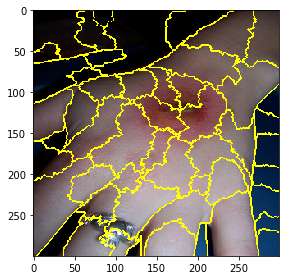

In [47]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))

The code above divides the image into "superpixels" or sub-images. This can be used to identify areas of the image that our model identifies as belonging to one class versus the other.

Next we will create perturbations, which allows us to turn off subpixels and isolate important superpixels. We'll start by generating random perturbations and then use the model to create perturbations.

In [50]:
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] #Show example of perturbation

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1])

In [51]:
def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

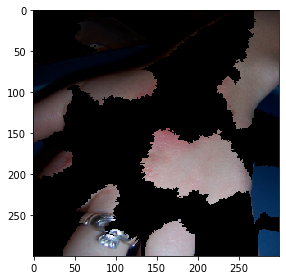

In [52]:
skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))

The image above shows the picture with random perturbations (superpixels shut off). Below, we will use our model to identify important superpixels and shut off the other ones.

In [53]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(Xi,pert,superpixels)
  pred = best_model.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

(150, 1, 2)

In [54]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

(150,)

In [55]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(150,)

In [56]:
class_to_explain = top_pred_classes[0]
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [57]:
num_top_features = 13
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

array([11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 12, 49])

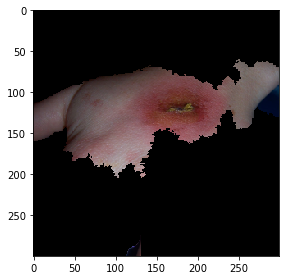

In [58]:
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels) )

In the image above we can see that the model is correctly keying on the infection site. This provides some confidence that the model is functioning properly.

# Conclusions

A CNN can be a valuable tool used in infection detection. With a small dataset, the CNN achieved ~90% accuracy and only a 4% false negative rate on the validation set. Further steps would need to be carried out before implementing a CNN within a patient portal; however, a tool such as this would have the potential to save patients money and time, free up doctors' schedules by only having them see patients at risk, and allow patients who would otherwise put off Dr.'s appointemnts catch infection early from the convenience of their homes. 

# Next Steps

There are several next steps that should be implemented before a technique such as this is used on real patients: 

**Gather More Data** Partner with providers to obtain larger dataset with medically reviewed labels.

**Add Classes** Create more nuanced classes for infection types and healing stages 

**Tweak Model** Continue to tune parameters with an eye on minimizing false negatives

**Launch App** Embed within patient portals such as MyChart so Dr. receives alert and uploaded images 